In [15]:
############################################################################
# Name: Liam Navarre, Connor Deide
# Class: CPSC 322, Fall 2022
# Final Project
# 12/14/2022
#
# Description: This file contains an overview of our project and shows how
# we have prepared, used, and interpreted the data from our input files
############################################################################

In [16]:
import os
import math
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from project_application import project_utils
importlib.reload(project_utils)
from classifier_models import classifiers
importlib.reload(classifiers)
from classifier_models import classifier_utils
importlib.reload(classifier_utils)
from classifier_models import evaluators as eval
importlib.reload(eval)
from classifier_models.classifiers import MyDummyClassifier as Dummy_clf
from classifier_models.classifiers import MyKNeighborsClassifier as KNeighbors_clf
from classifier_models.classifiers import MyNaiveBayesClassifier as NaiveBayes_clf


# Introduction

In [17]:
# Read the data from file
the_office_data_1 = pd.read_csv('./data/the_office_series.csv')
the_office_data_2 = pd.read_csv('./data/the_office_episodes.csv')

# Remove unwanted attributes from the two tables
# From dataframe 1
the_office_data_1.pop("EpisodeTitle")
the_office_data_1.pop("Votes")
the_office_data_1.pop("Date")
the_office_data_1.pop("Director")
the_office_data_1.pop("Writers")
# Want to descritize the about string into continuous values in the final project
the_office_data_1.pop("About")
# From dataframe 2
the_office_data_2.pop("Season")
the_office_data_2.pop("EpisodeNumInSeason")
the_office_data_2.pop("Title")
the_office_data_2.pop("WrittenBy")
the_office_data_2.pop("OriginalAirDate")
the_office_data_2.pop("ProdCode")

# Join the data on the EpisodeNumOverall attribute
    # Serves as a unique id
the_office_data = pd.merge(the_office_data_1, the_office_data_2, on="EpisodeNumOverall", how="outer")
display(the_office_data)

,EpisodeNumOverall,Season,Ratings,Viewership,Duration,GuestStars,DirectedBy,USViewers
0,0,1,7.5,11.20,23,NaN,Ken Kwapis,11200000.0
1,1,1,8.3,6.00,23,NaN,Ken Kwapis,6000000.0
2,2,1,7.8,5.80,22,NaN,Ken Whittingham,5800000.0
3,3,1,8.1,5.40,23,NaN,Bryan Gordon,5400000.0
4,4,1,8.4,5.00,23,NaN,Greg Daniels,5000000.0
...,...,...,...,...,...,...,...,...
183,183,9,8.0,3.83,22,NaN,Matt Sohn,3830000.0
184,184,9,8.0,3.25,22,NaN,Jesse Peretz,3250000.0
185,185,9,9.0,3.51,42,Michael Imperioli,Jeffrey Blitz,3510000.0
186,186,9,9.5,4.56,43,NaN,David Rogers,4560000.0


# Clean Data
* We are attempting to predict the IMDb ratings value for unseen instances
    * This value is a floating point number with one decimal, resulting in many possible ratings values
    * This large variation greatly decreases the probability of predicting a correct rating value
    * To help increase the probability, we decided to round the ratings values into integers so a rating value can fall between 0 and 10
* Below this python block is a graph showing the frequency of our ratings values after rounding

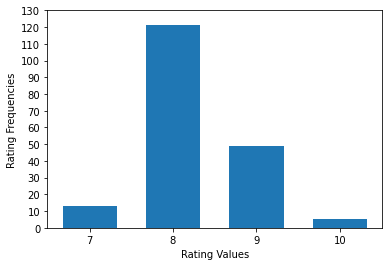

In [18]:
ratings_list = list(the_office_data.get("Ratings"))
round_ratings = []
for value in ratings_list:
    round_ratings.append(round(value))
# Replace Ratings column with rounded ratings
the_office_data["Ratings"] = round_ratings

ratings_freq = project_utils.get_instances(round_ratings)
# Prepare frequency data for matplotlib graph
xs = sorted(list(ratings_freq.keys()))
ys = []
for rating in xs:
    ys.append(ratings_freq[rating])
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys) + 10, 10)

plt.xlabel("Rating Values")
plt.ylabel("Rating Frequencies")
plt.bar(xrng, ys, .65)
plt.xticks(xrng, xs)
plt.yticks(yrng)

plt.show()

# Clean Data
* One more cleaning step is to modify the 'GuestStars' Column
    * The attribute value is left with a value 'N/A' if no guest star is present for that episode
* In order for our classifiers to better interpret this attribute, we will change the guest star domain to 1 or 0
    * This represents a true or false value, indicating whether there is a guest star in the episode or not

In [19]:
guest_stars_list = list(the_office_data.get("GuestStars"))
bool_guest_stars = []
for value in guest_stars_list:
    if type(value) != str:
        bool_guest_stars.append(0)
    else:
        bool_guest_stars.append(1)
# Replace Ratings column with rounded ratings
the_office_data["GuestStars"] = bool_guest_stars
display(the_office_data)

,EpisodeNumOverall,Season,Ratings,Viewership,Duration,GuestStars,DirectedBy,USViewers
0,0,1,8,11.20,23,0,Ken Kwapis,11200000.0
1,1,1,8,6.00,23,0,Ken Kwapis,6000000.0
2,2,1,8,5.80,22,0,Ken Whittingham,5800000.0
3,3,1,8,5.40,23,0,Bryan Gordon,5400000.0
4,4,1,8,5.00,23,0,Greg Daniels,5000000.0
...,...,...,...,...,...,...,...,...
183,183,9,8,3.83,22,0,Matt Sohn,3830000.0
184,184,9,8,3.25,22,0,Jesse Peretz,3250000.0
185,185,9,9,3.51,42,1,Jeffrey Blitz,3510000.0
186,186,9,10,4.56,43,0,David Rogers,4560000.0


# Getting Predictions
* To prove that we can get predictions from this dataset we will implement a Naive Bayes Classifier and use Stratified Cross Validation

In [20]:
# Extract and remove the Ratings column (y) from the dataframe
y = list(the_office_data.get("Ratings"))
the_office_data.pop("Ratings")
# Build X with the remaining data
X = the_office_data.values.tolist()

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 2)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 2)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 2)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()


Naive Bayes Classifier Report
Naive Bayes Classifier: accuracy = 0.88, error rate = 0.12
Precision:  0
Recall:  0
F-1:  0



### Reflection 
We found our Precision, Recall, and F-1 score to be 0 when we give it the prediction of 2. This is because currently our precision, recall, and F-1 score work soley with binary classification. Our data set is classified into 4 categories 